<a href="https://colab.research.google.com/github/CleanPegasus/Behavioural-Cloning/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data

In [1]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 34.14 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import random
import ntpath

## Data Visualisation

In [4]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
#pd.set_option['display.max_colwidth', -1]
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


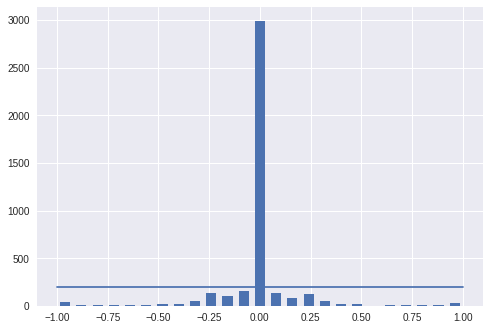

In [6]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed: 2790
remainind data:  1263


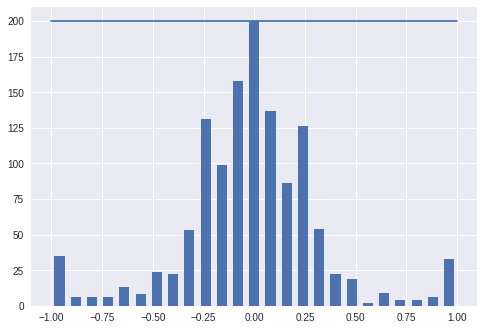

In [7]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
      
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remainind data: ', len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## Train Test Split

In [11]:
print(data.iloc[1])

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths, steering
  
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_44_485.jpg
left          left_2018_07_16_17_11_44_485.jpg
right        right_2018_07_16_17_11_44_485.jpg
steering                                 -0.25
throttle                              0.863326
reverse                                      0
speed                                  2.17305
Name: 13, dtype: object


In [0]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)

Text(0.5,1,'Validation Set')

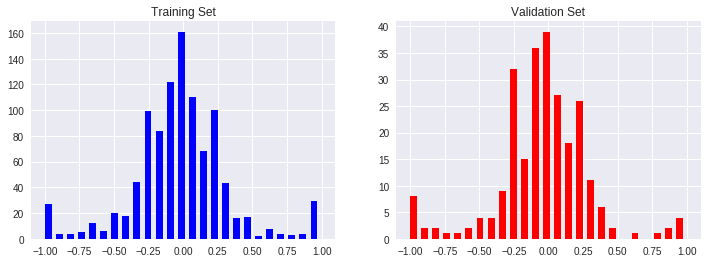

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axs[0].set_title('Training Set')
axs[1].hist(y_val, bins = num_bins, width = 0.05, color = 'red')
axs[1].set_title('Validation Set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135 , : , : ,]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5,1,'Preprocessed Image')

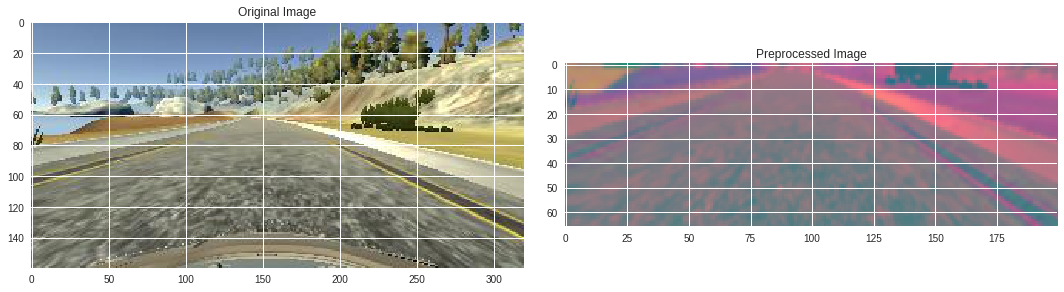

In [34]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(-0.5, 199.5, 65.5, -0.5)

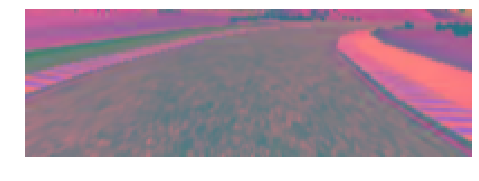

In [38]:
plt.imshow(X_train[10])
plt.axis('off')

## Nvidia Model

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'relu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'relu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'relu'))
  model.add(Convolution2D(64, 3, 3, activation = 'relu'))
  model.add(Convolution2D(64, 3, 3, activation = 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'relu'))
  model.add(Dense(10, activation = 'relu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model
  

In [46]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3),

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________